# Введение в искусственные нейронные сети
# Урок 7. Детектирование объектов

## Задание 1.
Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму
для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается
выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем
плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении
данной архитектуры на практике?

## Задание 2.
Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

## Решение

В научной работе «Faster R-CNN: Towards Real-Time Object Detection with Region Proposal
Networks» (Shaoqing Ren, Kaiming He, Ross Girshick, and Jian Sun) описана нейронная сеть для
детектирования и классификации объектов Faster R-CNN.
Архитектура Faster R-CNN объединяет Region Proposal Network (RPN) и Fast R-CNN в единую сеть
путем совместного использования их свертывающих характеристик, используя недавно популярную
терминологию нейронных сетей "механизмы внимания". RPN используется для генерации гипотез,
получая на вход карту признаков изначального изображения. Сеть Faster R-CNN строится на одних и тех
же весах с помощью следующего итеративного обучения:
1. Тренировка RPN сети. Сверточные слои инициализируются весами, натренированными на
ImageNet. Дообучаем на задаче определения регионов с каким-либо классом (уточнением
класса занимается часть Fast R-CNN).
2. Тренировка Fast R-CNN сети. Сверточные слои инициализируются весами, натренированными
на ImageNet. Дообучаем, используя гипотезы об объектах с помощью RPN сети, обученной в п.1.
В этот раз задачей обучения является уточнение координат и определение конкретного класса
объекта.
После выполнения п.2 мы имеем две нейронных сети с разными весами для сверточных слоев.
3. Обучаем только RPN часть, используя веса из п.2 (слои, идущие до RPN сети, принадлежащие
feature extractor, замораживаются и никак не изменяются).
4. Обучаем слои для Fast R-CNN, используя веса из п.3 (то есть, уже более точно настроенный RPN),
(остальные веса – идущие ранее или относящиеся к RPN — заморожены).
Таким образом, архитектура Faster R-CNN отличается от других архитектур тем, что генерация
гипотез выполняется с помощью отдельно дифференцируемого модуля и в архитектуре реализовано
итеративное обучение.
Преимуществом архитектуры Faster R-CNN являются быстрота и точность. Архитектура Faster RCNN справляется немного хуже с локализацией. RPN может быть трудно работать с объектами разных
масштабов. RPN имеет фиксированное приемное поле. Таким образом, малые объекты могут занимать
очень небольшую часть рецептивного поля или, если объекты очень большие, то рецептивное поле
будет содержать только часть объекта. Проблему можно решать, тренируя множество RPN для
различных масштабов: каждая часть RPN будет принимать различные сверточные слои или наборы
слоев в качестве входа, так что приемное поле будет разного размера. Это значительно улучшит
одновременное обнаружение малых и крупных объектов моделью Faster R-CNN.

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
%matplotlib inline

import tempfile

from six.moves.urllib.request import urlopen
from six import BytesIO

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time

from google.colab import files

import cv2 as cv

Загрузка изображения

In [16]:
files.upload()

Saving Savannah.jpg to Savannah (2).jpg


{'Savannah.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 85\n\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc0\x00\x11\x08\x02\xed\x04\xb0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x

## OpenCV - Selectiv Search

https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

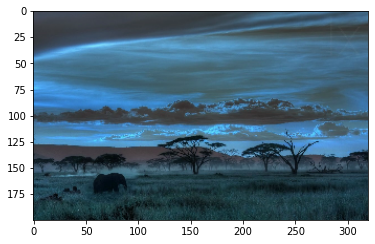

In [17]:
# Чтение изображения
im = cv.imread('/content/Savannah.jpg')
    
# размеры изображения
newH = 200  # высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 

#сжатие изображения
im = cv.resize(im, (newW, newH)) 
 
plt.imshow(im)
plt.show()

Selective Search (селективный поиск)

In [18]:
#Настройка модели
cv.setUseOptimized(True) # режим оптимизации
cv.setNumThreads(6)      # количество потоков

In [19]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

sss.setBaseImage(im)
  
sss.switchToSelectiveSearchQuality()

# Проведение selective search segmentation 
rects = sss.process() 

# Возврат массив прямоугольников, которые могут содержать объекты
print(rects.shape) # число найденых объектов

(1655, 4)


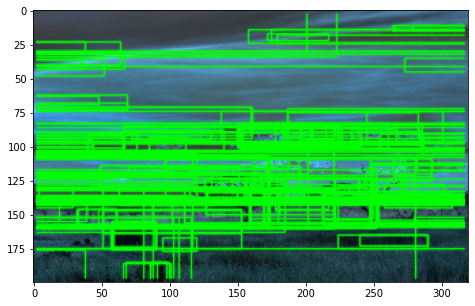

In [20]:
# Построение области

num_Rects = 200 # число выводимых region proposals (прямоугольников)

# Создание копии исходного изображения
im_ = im.copy()

for i, rect in enumerate(rects): 
  if (i < num_Rects): 
    # x, y - координаты левого верхнего угла; w, h - ширина и высота области
    x, y, w, h = rect
    # Построение рамки    
    cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
  else: 
    break 

# Вывод на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

https://github.com/opencv/opencv/tree/master/data/haarcascades

Запишем маршрут, где есть что-нибудь для чтения (последовательность из нескольких фотографий )



In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
root_path = './' 

## **Формирование и обработка результатов детектирования**


Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей

In [23]:
# Вывод изображения
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  if display:
    display_image(pil_image)
  return filename

#  Наложение рамки на изображение
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

 
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Загрузка детектора

In [24]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Формируем тензор

In [25]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)  
  return img

### Выполняем детектор на 100 рамок

In [26]:
max_frames = 100
def run_detector(detector, path):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()} 
  
  # Ограничиваем количество рамок значением 100
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [27]:
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      
      im_array.append(imf.copy())  
  return im_array

In [28]:
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

Чтение имен кадров 

In [29]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))

List_name[2]

array('./Savannah (2).jpg', dtype='<U18')

In [30]:
List_name[1]

array('./Savannah.jpg', dtype='<U14')

Проверка детектора

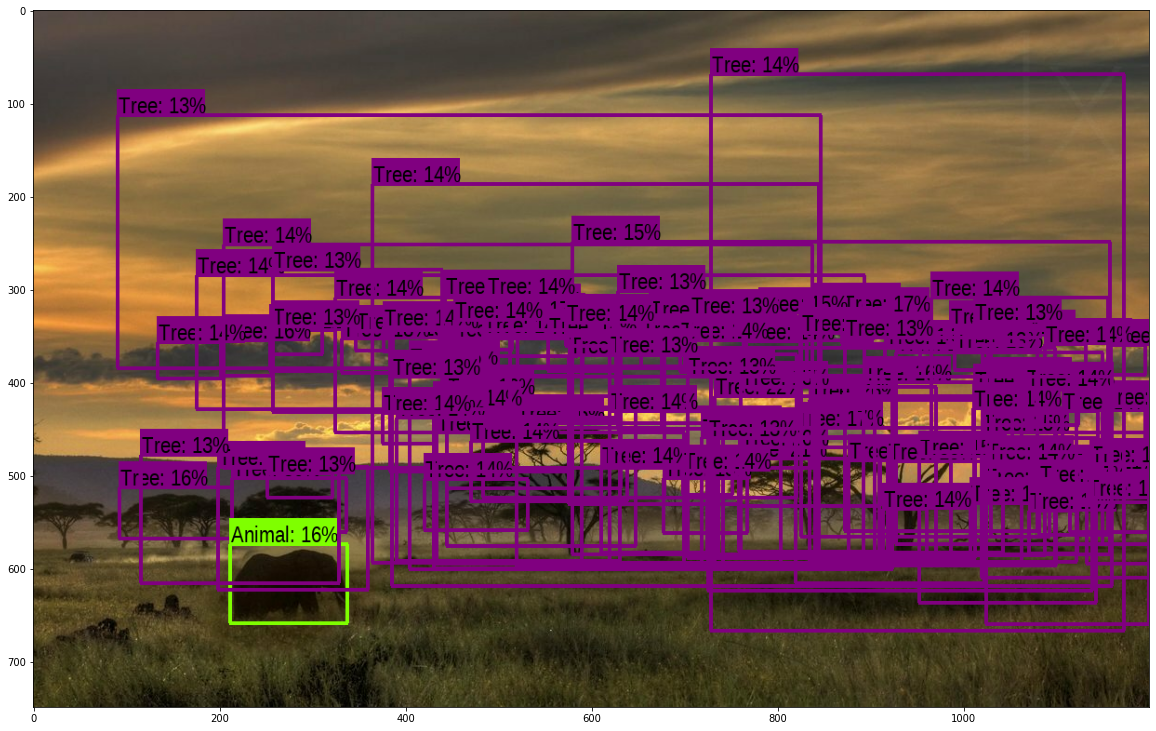

In [31]:
result_100 = run_detector(detector, List_name[2])

In [32]:
result_100

{'detection_boxes': array([[0.60653555, 0.36131474, 0.79412687, 0.5833795 ],
        [0.67286515, 0.17760378, 0.7477068 , 0.28112537],
        [0.5604827 , 0.695155  , 0.7912831 , 0.8861979 ],
        [0.5545954 , 0.6104763 , 0.7963138 , 0.91743   ],
        [0.61495304, 0.61351144, 0.78534186, 0.8449087 ],
        [0.6440049 , 0.6318018 , 0.7769194 , 0.76728374],
        [0.66151404, 0.9284461 , 0.74819446, 1.        ],
        [0.4598415 , 0.2118969 , 0.5170593 , 0.27156764],
        [0.43109736, 0.41203174, 0.496034  , 0.487622  ],
        [0.6285103 , 0.6333655 , 0.7113418 , 0.75991786],
        [0.42964414, 0.69889116, 0.47390845, 0.7527578 ],
        [0.47037733, 0.30379716, 0.5200339 , 0.37011543],
        [0.6137278 , 0.59857816, 0.79818344, 0.75853163],
        [0.47174615, 0.27657297, 0.5206176 , 0.32166877],
        [0.6836977 , 0.8519787 , 0.7543489 , 0.91108924],
        [0.6804532 , 0.9015846 , 0.7518288 , 0.9639152 ],
        [0.6469651 , 0.73006   , 0.7843322 , 0.822870

### Выполняем детектор на 50 рамок

In [33]:
max_frames = 50
def run_detector(detector, path):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()} 
  
  # Ограничиваем количество рамок значением 50
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

Возвращаем рамки для объектов

In [34]:
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      
      im_array.append(imf.copy())  
  return im_array

In [35]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

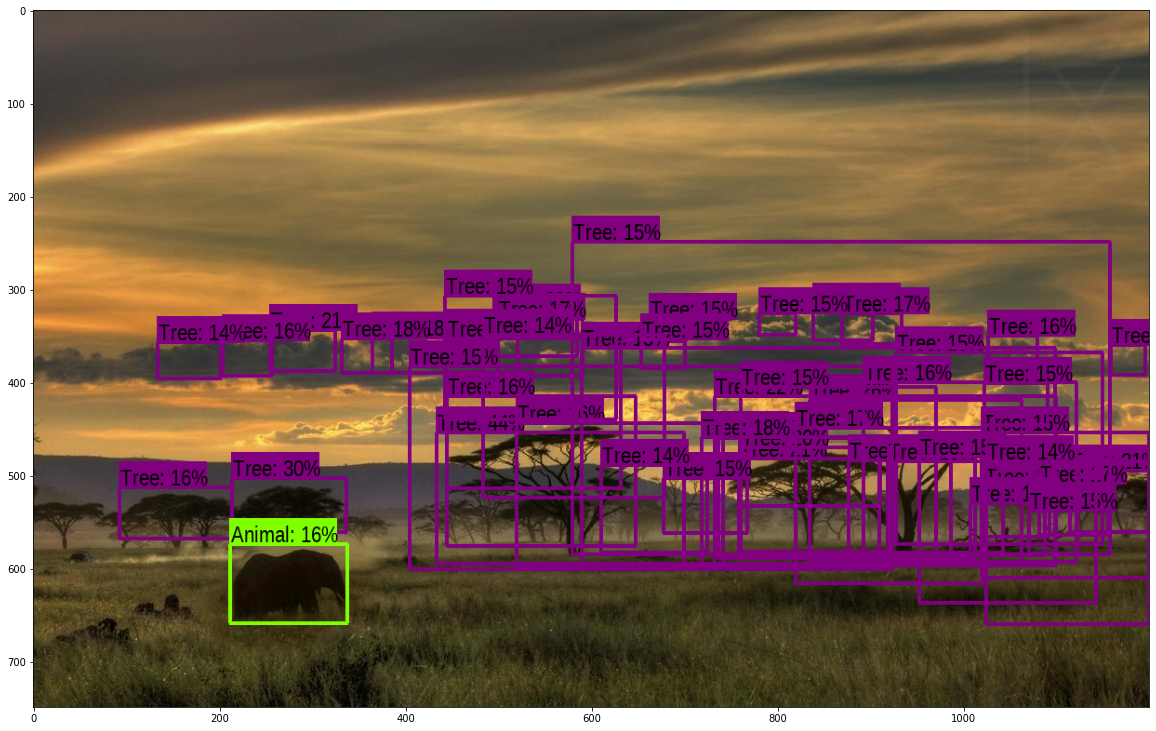

In [36]:
result_50 = run_detector(detector, List_name[2])

In [37]:
result_50

{'detection_boxes': array([[0.60653555, 0.36131474, 0.79412687, 0.5833795 ],
        [0.67286515, 0.17760378, 0.7477068 , 0.28112537],
        [0.5604827 , 0.695155  , 0.7912831 , 0.8861979 ],
        [0.5545954 , 0.6104763 , 0.7963138 , 0.91743   ],
        [0.61495304, 0.61351144, 0.78534186, 0.8449087 ],
        [0.6440049 , 0.6318018 , 0.7769194 , 0.76728374],
        [0.66151404, 0.9284461 , 0.74819446, 1.        ],
        [0.4598415 , 0.2118969 , 0.5170593 , 0.27156764],
        [0.43109736, 0.41203174, 0.496034  , 0.487622  ],
        [0.6285103 , 0.6333655 , 0.7113418 , 0.75991786],
        [0.42964414, 0.69889116, 0.47390845, 0.7527578 ],
        [0.47037733, 0.30379716, 0.5200339 , 0.37011543],
        [0.6137278 , 0.59857816, 0.79818344, 0.75853163],
        [0.47174615, 0.27657297, 0.5206176 , 0.32166877],
        [0.6836977 , 0.8519787 , 0.7543489 , 0.91108924],
        [0.6804532 , 0.9015846 , 0.7518288 , 0.9639152 ],
        [0.6469651 , 0.73006   , 0.7843322 , 0.822870

### Выполняем детектор на 10 рамок

In [38]:
max_frames = 10
def run_detector(detector, path):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()} 
  
  # Ограничиваем количество рамок значением 10
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_frames)

  display_image(image_with_boxes)
  return result

In [39]:
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])

      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      
      im_array.append(imf.copy())  
  return im_array

In [40]:
def get_boxes(image, boxes, class_names, scores, max_boxes=max_frames, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

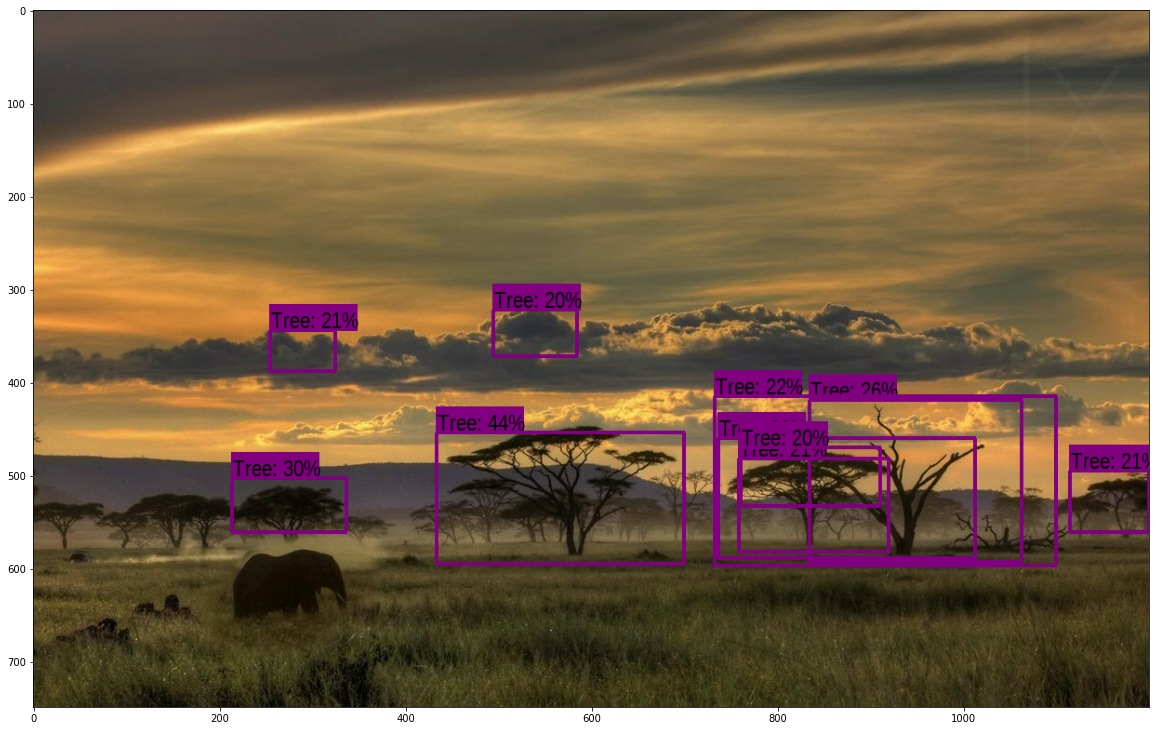

In [41]:
result_10 = run_detector(detector, List_name[2])

In [42]:
result_10

{'detection_boxes': array([[0.60653555, 0.36131474, 0.79412687, 0.5833795 ],
        [0.67286515, 0.17760378, 0.7477068 , 0.28112537],
        [0.5604827 , 0.695155  , 0.7912831 , 0.8861979 ],
        [0.5545954 , 0.6104763 , 0.7963138 , 0.91743   ],
        [0.61495304, 0.61351144, 0.78534186, 0.8449087 ],
        [0.6440049 , 0.6318018 , 0.7769194 , 0.76728374],
        [0.66151404, 0.9284461 , 0.74819446, 1.        ],
        [0.4598415 , 0.2118969 , 0.5170593 , 0.27156764],
        [0.43109736, 0.41203174, 0.496034  , 0.487622  ],
        [0.6285103 , 0.6333655 , 0.7113418 , 0.75991786],
        [0.42964414, 0.69889116, 0.47390845, 0.7527578 ],
        [0.47037733, 0.30379716, 0.5200339 , 0.37011543],
        [0.6137278 , 0.59857816, 0.79818344, 0.75853163],
        [0.47174615, 0.27657297, 0.5206176 , 0.32166877],
        [0.6836977 , 0.8519787 , 0.7543489 , 0.91108924],
        [0.6804532 , 0.9015846 , 0.7518288 , 0.9639152 ],
        [0.6469651 , 0.73006   , 0.7843322 , 0.822870